# Final Project for New Methods in Earth Observation

### Adeline Akansobe, Kwabena Antwi, André Luiz de Oliveira Domingues

#### Fall 2023 - Professor Lyndon Estes

In this project we run the Presto demo on TreeSat data and modify it to create predictions for all pixels in the test data. We then visualize the models predictions. The original demo can be found [here](https://github.com/nasaharvest/presto/blob/main/downstream_task_demo.ipynb). This demo was run on our local computers using docker.

# Using Presto for downstream tasks

The purpose of this notebook is to demonstrate how Presto (and utility functions in the Presto package) can be used for downstream tasks.

we decided to use two different (Pinus_nigra and Fraxinus_excelsior) tree species instead of the inital.

To do this, we used the [TreeSat](https://essd.copernicus.org/articles/15/681/2023/) benchmark dataset.

# Installations and imports

In [ ]:
%%capture
!! pip install xarray
!! pip install pyproj
!! pip install ee
!! pip install earthengine-api
!! pip install geopandas
!! pip install webdataset
!! pip install hurry
!! pip install hurry.filesize
!! pip install openmapflow
!! pip install einops

!! pip install rioxarray
!! pip install dask
!! pip install pystac_client
!! pip install typing_extensions==4.7.1
!! pip install planetary_computer
!! pip install leafmap
!! pip install geogif
!! pip install stackstac

!! pip install rio-cogeo

In [ ]:
# imports added by us
from pathlib import Path
from datetime import datetime
import numpy as np
import re
import os
from pathlib import Path
import rasterio
from subprocess import run
import matplotlib.pyplot as plt
import shutil
import pyproj

#---------------------------

from io import StringIO
import rioxarray
import xarray
from pyproj import Transformer
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from tqdm import tqdm

import torch
from torch.utils.data import DataLoader, TensorDataset

# import the model
import presto

# this is to silence the xarray deprecation warning.
# Our version of xarray is pinned, but we'll need to fix this
# when we upgrade
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Access data

This tutorial requires the S2 data to be downloaded from [Zenodo](https://zenodo.org/record/6780578) and unzipped in the [treesat folder](data/treesat).

If the TreeSat data has been correctly downloaded from Zenodo (see the Markdown cell above), these assert statements should pass.

In [ ]:
# Define paths

# Treesat folder path
treesat_folder = presto.utils.data_dir / "treesat"
assert treesat_folder.exists()

# path to Sentinel 2 (s2) 60m resolution images
s2_data_60m = treesat_folder / "s2/60m"
assert s2_data_60m.exists()


In [ ]:
ALL_SPECIES = set()

# Reading filenames from the directory
for file in treesat_folder.glob("*.tif"):
    parts = file.stem.split('_')  # .stem gives the filename without the suffix
    tree_name = '_'.join(parts[:2])  # Join the first two parts
    ALL_SPECIES.add(tree_name)

# Reading additional filenames from train_filenames.lst
with (treesat_folder / "train_filenames.lst").open("r") as f:
    for line in f:
        parts = line.strip().split('_')
        tree_name = '_'.join(parts[:2])
        ALL_SPECIES.add(tree_name)

# Print the unique tree names
for name in ALL_SPECIES:
    print(name)

print(len(ALL_SPECIES))

Alnus_spec.
Populus_spec.
Quercus_petraea
Abies_alba
Pseudotsuga_menziesii
Picea_abies
Acer_pseudoplatanus
Larix_kaempferi
Tilia_spec.
Fagus_sylvatica
Cleared_0
Fraxinus_excelsior
Larix_decidua
Prunus_spec.
Quercus_rubra
Pinus_sylvestris
Pinus_strobus
Betula_spec.
Quercus_robur
Pinus_nigra
20


We adapted the same number and tree species (Abies_alba and Acer_pseudoplatanus) for classification.

The TreeSatAI S2 data contains the following bands: ["B2", "B3", "B4", "B8", "B5", "B6", "B7", "B8A", "B11", "B12", "B1", "B9"]

In [ ]:
TREESATAI_S2_BANDS = ["B2", "B3", "B4", "B8", "B5", "B6", "B7", "B8A", "B11",
                      "B12", "B1", "B9"]


# Tree species names
SPECIES = ["Pinus_nigra", "Fraxinus_excelsior"] #2946

### 1. Processing the data
#### The TreeSatAI data is stored in `.tif` files with 6 by 6 pixel chips at 10 meter resolution. We modified this section to extract all 36 pixels from the input data chips. The original demo only extracted 9 pixels to construct the input data.

In [ ]:
# Modified to take all pixels in input chips.
INDICES_IN_TIF_FILE = list(range(0, 6, 1))

# Create lists of train and test files for the two species
with (treesat_folder / "train_filenames.lst").open("r") as f:
    train_files = [line for line in f if (line.startswith(SPECIES[0]) or
                                          line.startswith(SPECIES[1]))]
with (treesat_folder / "test_filenames.lst").open("r") as f:
    test_files = [line for line in f if (line.startswith(SPECIES[0]) or
                                         line.startswith(SPECIES[1]))]

print(f"{len(train_files)} train files and {len(test_files)} test files")

2756 train files and 299 test files


### Here the model defines the function that will process the train and test data.
#### We added modifications (.to(device)) to try and run the tensors on GPU.

We use `presto.construct_single_presto_input` to transform the TreeSat S2 data into the tensors expected by Presto.

In [ ]:
# Adapted to run training with GPU instead of CPU

def process_images(filenames, device='cpu'):
    arrays, masks, latlons, image_names, labels, \
    dynamic_worlds = [], [], [], [], [], []

    for filename in tqdm(filenames):
        # for each tif file get the crs and transform the crs to 4326
        tif_file = rioxarray.open_rasterio(s2_data_60m / filename.strip())
        crs = tif_file.rio.crs
        transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)

        #Nested y loop in x loop means that the model will process all the rows
        #in a column before moving on to the next column
        for x_idx in INDICES_IN_TIF_FILE:
            for y_idx in INDICES_IN_TIF_FILE:

                # First, get the latitudes and longitudes
                # and convert to tensor using PyTourch
                x, y = tif_file.x[x_idx], tif_file.y[y_idx]

                lon, lat = transformer.transform(x, y)

                latlons.append(torch.tensor([lat, lon]).to(device))

                # then, get the eo_data, mask and dynamic world
                s2_data_for_pixel = torch.from_numpy(
                    tif_file.values[:, x_idx, y_idx].astype(int)).float()
                #print('s2_data_for_pixel: ', s2_data_for_pixel) ###

                s2_data_with_time_dimension = s2_data_for_pixel.unsqueeze(0)
                #print('s2_data_with_time_dimension: ',
                #s2_data_with_time_dimension) ###

                x, mask, dynamic_world = presto.construct_single_presto_input(
                    s2=s2_data_with_time_dimension, s2_bands=TREESATAI_S2_BANDS
                )

                arrays.append(x.to(device))
                masks.append(mask.to(device))
                dynamic_worlds.append(dynamic_world.to(device))

                # Label species with abies with 0 and the other as 1
                labels.append(0 if filename.startswith("Pinus") else 1)
                image_names.append(filename)

    return (torch.stack(arrays, axis=0),
            torch.stack(masks, axis=0),
            torch.stack(dynamic_worlds, axis=0),
            torch.stack(latlons, axis=0),
            torch.tensor(labels).to(device),
            image_names,
        )

#### Process the training and test data.
Process the data by mapping the function for the tensors
to the train and test data.


In [ ]:
# Set function to run training on GPU (Cuda)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# map function processed image and GPU to train and test data
train_data = process_images(train_files, device=device)
test_data = process_images(test_files, device=device)

100%|█████████████████████████████████████████| 299/299 [00:19<00:00, 15.28it/s]


### 2. Using Presto as a feature extractor for a random forest

One way to use Presto is as a feature extractor for a simple model (e.g. a Random Forest). We do this below.

We load the pretrained Presto model using `Presto.load_pretrained()`.

In [ ]:
batch_size = 64

pretrained_model = presto.Presto.load_pretrained()
pretrained_model.eval()

Presto(
  (encoder): Encoder(
    (eo_patch_embed): ModuleDict(
      (S1): Linear(in_features=2, out_features=128, bias=True)
      (S2_RGB): Linear(in_features=3, out_features=128, bias=True)
      (S2_Red_Edge): Linear(in_features=3, out_features=128, bias=True)
      (S2_NIR_10m): Linear(in_features=1, out_features=128, bias=True)
      (S2_NIR_20m): Linear(in_features=1, out_features=128, bias=True)
      (S2_SWIR): Linear(in_features=2, out_features=128, bias=True)
      (ERA5): Linear(in_features=2, out_features=128, bias=True)
      (SRTM): Linear(in_features=2, out_features=128, bias=True)
      (NDVI): Linear(in_features=1, out_features=128, bias=True)
    )
    (dw_embed): Embedding(10, 128)
    (latlon_embed): Linear(in_features=3, out_features=128, bias=True)
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=128, out_features=384, bias=True)

We construct features for the training data, and use this to train the Random Forest.

In [ ]:
# the treesat AI data was collected during the summer,
# thus 6th month (July) used for the 123480 train pixels.
month = torch.tensor([6] * train_data[0].shape[0]).long()

# create a dataset from the tensors of x[0], mask[1],
# dynamic worlds[2] and latlons datatype[3] and month
dl = DataLoader(
    TensorDataset(
        train_data[0].float(),  # x
        train_data[1].bool(),  # mask
        train_data[2].long(),  # dynamic world
        train_data[3].float(),  # latlons
        month
    ),
    batch_size=batch_size,
    shuffle= False,
)

In [ ]:
pretrained_model = pretrained_model.to(device)  # Move model to GPU

# prediction features for the train data tensors
features_list = []
for (x, mask, dw, latlons, month) in tqdm(dl):
    x, mask, dw, latlons, month = (x.to(device), mask.to(device),
                                   dw.to(device),latlons.to(device),
                                   month.to(device))  # Move all tensors to GPU

    with torch.no_grad():
        encodings = pretrained_model.encoder(x, dynamic_world=dw, mask=mask,
                                             latlons=latlons, month=month)
        encodings = encodings.cpu().numpy()  # Move encodings back to CPU
        features_list.append(encodings)

features_np = np.concatenate(features_list)

100%|███████████████████████████████████████| 1551/1551 [00:17<00:00, 87.34it/s]


### Run the model
#### We use `features_np` to train a Random Forest classifier:

In [ ]:
# Run the model on a random forest classifier
model = RandomForestClassifier(class_weight="balanced", random_state=42)

if device == 'cpu':
    # ORIGINAL CODE THAT JUST USED CPU
    model.fit(features_np, train_data[4].numpy())
else:
    # ADAPTED WITH GPU. MUST CONVERT BACK TO CPU TO CONVERT TENSOR TO NUMPY
    model.fit(features_np, train_data[4].cpu().numpy())


#### Similarly, we construct features for the test data, use the trained random forest
#### to make some predictions on the test data.

In [ ]:
# the treesat AI data was collected during the summer,
# thus 6th month (July) used for the 13500 train pixels.
month = torch.tensor([6] * test_data[0].shape[0]).long()

# create a dataset from the tensors of x[0], mask[1], dynamic worlds[2]
# and latlons datatype[3] and month
dl = DataLoader(
    TensorDataset(
        test_data[0].float(),
        test_data[1].bool(),
        test_data[2].long(),
        test_data[3].float(),
        month
    ),
    batch_size=batch_size,
    shuffle=False,
)

In [ ]:
# Move model to GPU
#pretrained_model = pretrained_model.to(device)


# test predictions for all test data
#features_list = []
#for (x, mask, dw, latlons, month) in tqdm(dl):

    #x, mask, dw, latlons, month = (x.to(device), mask.to(device),
                                   #dw.to(device),latlons.to(device),
                                   #month.to(device))  # Move all tensors to GPU

    #with torch.no_grad():
        #encodings = pretrained_model.encoder(x, dynamic_world=dw, mask=mask,
                                             #latlons=latlons, month=month)
        #encodings = encodings.cpu().numpy()  # Move encodings back to CPU
        #features_list.append(encodings)

#features_np = np.concatenate(features_list)

# The prediction output
## Apply the model to predict pixels on the test files.



In [ ]:
latlons_list = []
test_preds = []

for (x, mask, dw, latlons, month) in tqdm(dl):
    with torch.no_grad():
        pretrained_model.eval()
        encodings = pretrained_model.encoder(
            x, dynamic_world=dw, mask=mask, latlons=latlons, month=month
        ).cpu().numpy()

        # Get predictions and append to test_preds list
        test_preds.append(model.predict_proba(encodings))

        # Append latlons for each batch to latlons_list
        latlons_list.append(latlons.cpu().numpy())

100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 59.52it/s]


### We take the mode of the 36 pixels we processed as the prediction for a single image

In [ ]:
# Process predictions
pix_per_image = len(INDICES_IN_TIF_FILE) ** 2

# transform the predictions into 3D array
test_preds_np = np.concatenate(test_preds, axis=0)
test_preds_np = np.reshape(
    test_preds_np,
    (int(len(test_preds_np) / pix_per_image),
     pix_per_image, test_preds_np.shape[-1]),
)
# then, take the mode of the model predictions for the test data
test_preds_np_argmax = stats.mode(
    np.argmax(test_preds_np, axis=-1), axis=1, keepdims=False
)[0]

# transform the latlons into 3D array
latlons_np = np.concatenate(latlons_list, axis=0)
latlons_np = np.reshape(latlons_np, (int(len(latlons_np) / pix_per_image),
                                     pix_per_image, -1))


## Display the results of the prediction on two images of the test data.

In [ ]:
def print_image_predictions(img_index_first, img_index_last=None,
                            SPECIES=SPECIES, test_preds_np=test_preds_np,
                            test_preds_np_argmax=test_preds_np_argmax,
                            latlons_np=latlons_np):
    if img_index_last is None:
        img_index_last = img_index_first

    img_index_range = range(img_index_first, img_index_last + 1)

    for img_index in img_index_range:
        if img_index >= len(test_preds_np):
            print(f"Image index {img_index} is out of range.")
            continue

        mode_prediction = test_preds_np_argmax[img_index]
        mode_species = SPECIES[mode_prediction]
        print(f"Mode Prediction for Image {img_index}:" \
                  f"{mode_prediction} ({mode_species})\n")

        header = f"{'Pixel Index':<12} {'Prediction':<30}" \
                    f"{'Species Proportions':<30} {'Lat, Lon':<30}"
        print(header)
        print("-" * len(header))

        for pixel_index in range(pix_per_image):
            pixel_pred_index = np.argmax(test_preds_np[img_index, pixel_index])
            pixel_species = SPECIES[pixel_pred_index]
            pixel_latlon = latlons_np[img_index, pixel_index]
            class_proportions = test_preds_np[img_index, pixel_index]
            row = f"{pixel_index:<12} {pixel_pred_index} ({pixel_species:<})"\
            f"{'' :>15} {str(class_proportions):<30} {str(pixel_latlon):<30}"
            print(row)

        print("\n")

# Example Usage
print_image_predictions(24, 25)


Mode Prediction for Image 24:1 (Fraxinus_excelsior)

Pixel Index  Prediction                    Species Proportions            Lat, Lon                      
--------------------------------------------------------------------------------------------------------
0            1 (Fraxinus_excelsior)                [0.04 0.96]                    [51.605843 10.569197]         
1            1 (Fraxinus_excelsior)                [0.04 0.96]                    [51.60575  10.569194]         
2            1 (Fraxinus_excelsior)                [0.18 0.82]                    [51.60566 10.56919]           
3            1 (Fraxinus_excelsior)                [0.04 0.96]                    [51.60557  10.569187]         
4            1 (Fraxinus_excelsior)                [0.02 0.98]                    [51.60548  10.569184]         
5            1 (Fraxinus_excelsior)                [0. 1.]                        [51.605392 10.569181]         
6            1 (Fraxinus_excelsior)                [0.03 0.

And finally, we can compute the F1 score of the test predictions.

In [ ]:
if device == 'cpu':
    # ORIGINAL THAT JUST USED CPU
    target = np.reshape(test_data[4].cpu(),
                            (int(len(test_data[4]) / pix_per_image),
                             pix_per_image))[:, 0]
else:
    # CODE FOR GPU USE
    target = np.reshape(test_data[4].cpu(),
                    (int(len(test_data[4]) / pix_per_image),
                                         pix_per_image))[:, 0]

#Print F1 score
f1_score(target, test_preds_np_argmax, average="weighted")

0.9793156238321346

# Export predictions

#### Remove \n from test_files name so that code will work with Path function

In [ ]:
# Remove \n from file names in .lst doc. (possible bug)
test_files = [re.sub("\n", "", f) for f in test_files]
print(test_files[0])

Fraxinus_excelsior_10_173918_BI_NLF.tif


## Save predictions as tifs

In [ ]:
# Redefine the paths for input60m and predictions if needed

#Path for test files
test_file_paths = [Path(f"{s2_data_60m}/{img}") for img in test_files]

# Other initializations
prediction_number = 1
current_date = datetime.now().strftime("%Y-%m-%d")
output_folder_name = f"{prediction_number}_{len(SPECIES)}species_{current_date}"
#Path to save predictions
predictions_path = "/home/workdir/predictions2"
output_dir = Path(f"{predictions_path}/{output_folder_name}")
output_dir.mkdir(parents=True, exist_ok=True)

#Function to add prediction band to test files
def add_prediction_band(raster_path, predictions, output_path):
    with rasterio.open(raster_path) as src:
        meta = src.meta
        data = src.read()
        new_data = np.append(data, predictions[np.newaxis, :, :], axis=0)
        meta.update(count=new_data.shape[0])
        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(new_data)

# Process each file and save the output
for idx, raster_path in enumerate(test_file_paths):
    absolute_path = (Path(s2_data_60m) / raster_path.name)
    try:
        with rasterio.open(absolute_path) as src:
            # Apply np.argmax along axis 1 to get the index of max value
            # (class) for each pixel
            preds_for_raster = np.argmax(test_preds_np[idx], axis=1)
            preds_for_raster = preds_for_raster.reshape(
                (src.height, src.width))  # Reshape to image dimensions

            output_path = output_dir / f'{raster_path.stem}_predicted_{idx}.tif'
            add_prediction_band(absolute_path, preds_for_raster, output_path)
    except Exception as e:
        print(f"Error processing file {raster_path}: {e}")


## Transform the prediction tifs into COGs

Since we are working with small output files, this step could be skipped.


In [ ]:
#Function TO COGIFY
def cogify(input_tif):
    output_cog = re.sub('.tif', '_cog.tif', input_tif)
    cmd = ['rio', 'cogeo', 'create', input_tif, output_cog]
    p = run(cmd, capture_output=True)
    if p.returncode != 0:
        print(f"Error in COG creation: {p.stderr.decode()}")
        return
    #print(f"COG created: {output_cog}")

    # Validate the COG
    cmd = ['rio', 'cogeo', 'validate', output_cog]
    p = run(cmd, capture_output=True)
    #print(f'Validation result: {p.stdout.decode()}')

    if os.path.exists(output_cog):
        os.remove(input_tif)

# Specify the output directory containing the TIFF files, overwriting
output_dir = Path(f"{predictions_path}/{output_folder_name}")

# Iterate over each TIFF file in the output directory
# tiffs are replaced with COGS(geotiffs)
for tif_file in output_dir.glob("*.tif"):
    cogify(str(tif_file))

### Visualize and test if saved files have correct prediction values

In [ ]:
output_dir

PosixPath('/home/workdir/predictions2/1_2species_2023-12-19')

In [ ]:
#Output path
output_dir = Path(f"{predictions_path}/{output_folder_name}")

# Get the name of the first file in test_file_paths for reference
original_file = test_file_paths[24].stem


# Construct the path to the first saved raster file
saved_file = f'{output_dir}/{original_file}_predicted_24_cog.tif'

# Open the raster file and read the last band (prediction band)
with rasterio.open(saved_file) as src:
    # Assuming the prediction band is the last band
    prediction_band = src.read(src.count)

    # Print the pixel values of the prediction band
    print("Prediction Band Pixel Values:")
    print(prediction_band)

    # Since we have opened the src here, we can now get its dimensions
    src_height, src_width = src.height, src.width

# Optionally, you can also compare it to test_preds_np[0]
# Reshape it to match the dimensions of the source image
expected_predictions = (np.argmax(test_preds_np[24], axis=1)
                        .reshape((src_height, src_width)))
print("\nExpected Predictions from test_preds_np[0]:")
print(expected_predictions)


Prediction Band Pixel Values:
[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 0 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]]

Expected Predictions from test_preds_np[0]:
[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 0 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]]


# Extract and Visualize Distribution of Tree species
### Identify the mode species of each image and sparate them into folders by majority species.

In [ ]:
#prediction_tiffs_folder_path

In [ ]:
# Paths and variable definitions
prediction_tiffs_folder_path = str(predictions_path / output_dir)
mode_species0_dir = os.path.join(prediction_tiffs_folder_path, "mode_species0")
mode_species1_dir = os.path.join(prediction_tiffs_folder_path, "mode_species1")

# Create directories if they don't exist
os.makedirs(mode_species0_dir, exist_ok=True)
os.makedirs(mode_species1_dir, exist_ok=True)

# Number of classes based on the SPECIES list
num_classes = len(SPECIES)

# Initialize counters for majority species 0 and majority species 1
maj_sp0 = 0
maj_sp1 = 0

# Initialize a dictionary to hold the counts for each file
pixel_counts = (
    {
        filename: [0] * num_classes
        for filename in os.listdir(prediction_tiffs_folder_path)
        if filename.endswith('.tif')
    }
)

# Loop through all the files in the directory
for filename in pixel_counts:
    filepath = os.path.join(prediction_tiffs_folder_path, filename)

    # Open the TIFF file
    with rasterio.open(filepath) as dataset:
        # Read the data from the 13th band
        array = dataset.read(13)

        # Count the number of pixels for each class
        for class_idx in range(num_classes):
            pixel_counts[filename][class_idx] = (array == class_idx).sum()

        # Check if majority species is 0 or 1
        if max(pixel_counts[filename]) == pixel_counts[filename][0]:
            maj_sp0 += 1
            # Save a copy of mode 0 in a new folder
            shutil.copy(filepath, mode_species0_dir)
        else:
            maj_sp1 += 1
            # Save a copy of mode 1 in a new folder
            shutil.copy(filepath, mode_species1_dir)



## Graph the distribution of tree species in each prediction image.
#### Graph also shows the majority porportions of all the images. <br>
26% of all the predictions had a majority of Abies_alba species. <br>
74% of all the predictions had a majority of Abies_alba species.

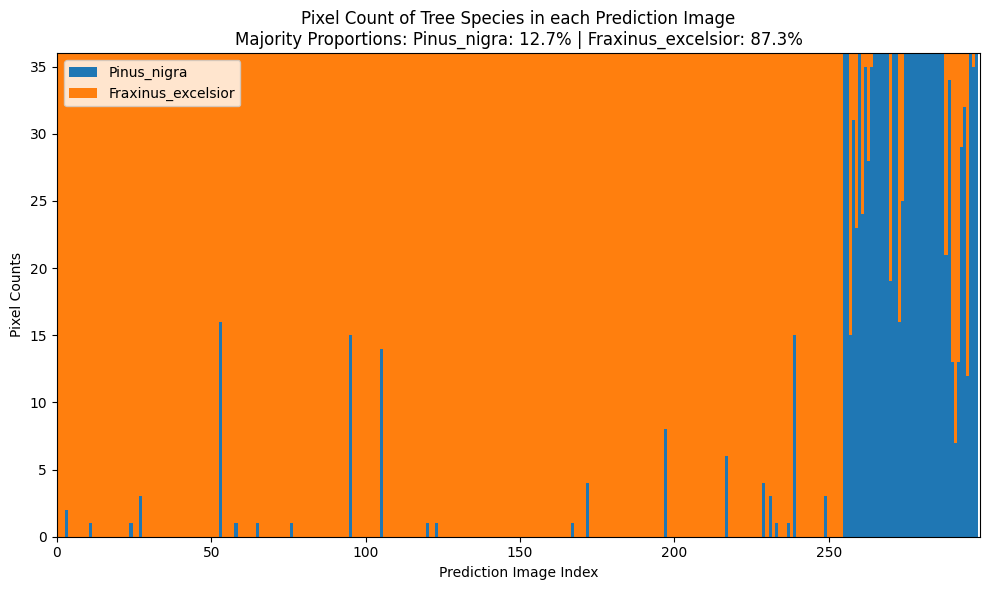

In [ ]:
# Preparing the data for the stacked histogram
counts_matrix = list(zip(*pixel_counts.values()))

# Creating the stacked histogram
plt.figure(figsize=(10, 6))
bar_width = 1  # No gap between bars

# Plotting bars for each class
bottom_heights = [0] * len(pixel_counts)
for class_idx in range(num_classes):
    plt.bar(
        range(len(pixel_counts)),
        counts_matrix[class_idx],
        width=bar_width,
        bottom=bottom_heights,
        label=SPECIES[class_idx]
    )
    bottom_heights = [sum(x) for x in zip(bottom_heights,
                                          counts_matrix[class_idx])]

# Adding the counts to the x-label
plt.ylabel('Pixel Counts')
plt.xlabel(f'Prediction Image Index')
plt.title(
    f'Pixel Count of Tree Species in each Prediction Image\n'
    f'Majority Proportions: {SPECIES[0]}: '
    f'{round(maj_sp0 / (maj_sp0 + maj_sp1) * 100, 1)}% | '
    f'{SPECIES[1]}: '
    f'{round(maj_sp1 / (maj_sp0 + maj_sp1) * 100, 1)}%'
)
plt.xlim([0, len(pixel_counts)])  # Set x-axis limits
plt.legend()
plt.tight_layout()
plt.show()

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
# Visualize Predictions on Map - Switch to Colab
## Run the rest of the code starting here on google Colab.

 Visualization was not working in docker so we switched platforms.
 Prediction files are shared at this [link](https://drive.google.com/drive/folders/1bv603KSzP5ad9GWg8iux4LmDetdJhHlM?usp=drive_link).

# Imports and installs to run the section seperately on Colab.

In [1]:
%%capture
%pip install localtileserver
%pip install leafmap

In [2]:
import os
import rasterio
from rasterio.warp import transform_bounds
import leafmap.leafmap as leafmap
import localtileserver
import random
import pyproj

In [3]:
from google.colab import drive
root = '/content/gdrive'
drive.mount(root)

Mounted at /content/gdrive


## Import data

In [4]:
# Actual test file for the mixed classes
test_dir = f"{root}/MyDrive/EarthObservations/Presto_Project/data/Test_files"

# Path to folder
predictions_dir = f"{root}/MyDrive/EarthObservations/Presto_Project/data/predictions2"
species0_dir = f"{predictions_dir}/mode_species0"
species1_dir = f"{predictions_dir}/mode_species1"

# # File paths
prediction24_cog = f"{predictions_dir}/" \
     "Fraxinus_excelsior_2_30386_WEFL_NLF_predicted_24_cog.tif"

#actual image of Fraxinus_excelsior_24
test24 = f"{test_dir}/" \
     "Fraxinus_excelsior_2_30386_WEFL_NLF.tif"


## Visualize prediction raster examples in leafmap
The prediction rasters are saved in a public [gdrive folder](https://drive.google.com/drive/folders/1ptCCcaZVrW9MAsWnMIQ5lssLRi9oWj5e?usp=drive_link).

Here is an example of chip was predicted as Fraxinus_excelsior, the mode of the classes.
Fraxinus_excelsior_2_30386_WEFL_NLF_predicted_24_cog.tif:

<table>
  <tr>
    <td>[1</td> <td>1</td> <td>1</td> <td>1</td> <td>1</td> <td>1]</td>
  </tr>
  <tr>
    <td>[1</td> <td>1</td> <td>1</td> <td>1</td> <td>1</td> <td>1]</td>
  </tr>
  <tr>
    <td>[1</td> <td>1</td> <td>1</td> <td>1</td> <td>0</td> <td>1]</td>
  </tr>
  <tr>
    <td>[1</td> <td>1</td> <td>1</td> <td>1</td> <td>1</td> <td>1]</td>
  </tr>
  <tr>
    <td>[1</td> <td>1</td> <td>1</td> <td>1</td> <td>1</td> <td>1]</td>
  </tr>
  <tr>
    <td>[1</td> <td>1</td> <td>1</td> <td>1</td> <td>1</td> <td>1]</td>
  </tr>
</table>



# Map the distribution of all tree species majority images.
Notice that Pinus_nigra is the predominant species in northern Germany.
And Fraxinus_excelsior is the predominant species in southern Germany.

In [5]:
# Function to get the center (lat, lon) of a raster in EPSG:4326
def get_raster_center(raster_path):
    with rasterio.open(raster_path) as src:
        bounds = src.bounds
        lon = (bounds.left + bounds.right) / 2
        lat = (bounds.bottom + bounds.top) / 2
        # Perform coordinate transformation to EPSG:4326
        transformer = pyproj.Transformer.from_crs(src.crs, 'EPSG:4326', always_xy=True)
        lon, lat = transformer.transform(lon, lat)
        lat = lat
    return lat, lon

# Create a Leafmap map centered at an initial location
m = leafmap.Map(center=[52.4, 9.5], zoom=7)

# List and process the TIFF files in species0_dir
species0_files = [f for f in os.listdir(species0_dir) if f.endswith('.tif')]
#species0_files_count = len(species0_files)
#print(species0_files_count)
for filename in species0_files:
    filepath = os.path.join(species0_dir, filename)
    lat, lon = get_raster_center(filepath)
    # White markers for species 0
    m.add_markers([lat, lon], shape='circle', color='#FFFFFF')

# List and process the TIFF files in species1_dir
species1_files = [f for f in os.listdir(species1_dir) if f.endswith('.tif')]
for filename in species1_files:
    filepath = os.path.join(species1_dir, filename)
    lat, lon = get_raster_center(filepath)
    # Red markers for species 1
    m.add_markers([lat, lon], shape='circle', color='#ff0000')


labels = ['Pinus_nigra', 'Fraxinus_excelsior']

colors = ['#FFFFFF', '#ff0000']


m.add_legend(title='Legend', labels=labels,
             colors=colors)

# Add basemap
m.add_basemap("SATELLITE")

# Display the map
m

Map(center=[52.4, 9.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

## Randomly select 10 rasters of each species majority

In [6]:
predictions_dir = f"{root}/MyDrive/EarthObservations/Presto_Project/data/predictions2"
species0_dir = os.path.join(predictions_dir, "mode_species0")
species1_dir = os.path.join(predictions_dir, "mode_species1")

# Set a seed for reproducibility
random.seed(42)

# List files in each directory
species0_files = [os.path.join(species0_dir, f) for f in os.listdir(species0_dir) if f.endswith('.tif')]
species1_files = [os.path.join(species1_dir, f) for f in os.listdir(species1_dir) if f.endswith('.tif')]

# Randomly select up to 10 rasters from each category
selected_species0 = random.sample(species0_files, min(len(species0_files), 10))
selected_species1 = random.sample(species1_files, min(len(species1_files), 10))

# Print selected file names
print('Selected Pinus_nigra (species0) images:')
for filepath in selected_species0:
    print(os.path.basename(filepath))
print()

print('Selected Fraxinus_excelsior (species1) images:')
for filepath in selected_species1:
    print(os.path.basename(filepath))


Selected Pinus_nigra (species0) images:
Pinus_nigra_2_51340_WEFL_NLF_predicted_259_cog.tif
Pinus_nigra_3_53993_WEFL_NLF_predicted_270_cog.tif
Pinus_nigra_6_50459_WEFL_NLF_predicted_287_cog.tif
Pinus_nigra_4_53705_WEFL_NLF_predicted_276_cog.tif
Pinus_nigra_2_52538_WEFL_NLF_predicted_264_cog.tif
Pinus_nigra_2_52488_WEFL_NLF_predicted_263_cog.tif
Pinus_nigra_2_54369_WEFL_NLF_predicted_265_cog.tif
Pinus_nigra_4_53138_WEFL_NLF_predicted_275_cog.tif
Pinus_nigra_5_50048_WEFL_NLF_predicted_277_cog.tif
Pinus_nigra_5_53082_WEFL_NLF_predicted_281_cog.tif

Selected Fraxinus_excelsior (species1) images:
Fraxinus_excelsior_2_32361_WEFL_NLF_predicted_46_cog.tif
Fraxinus_excelsior_6_31846_WEFL_NLF_predicted_210_cog.tif
Fraxinus_excelsior_1_33995_WEFL_NLF_predicted_14_cog.tif
Fraxinus_excelsior_2_16198_BI_NLF_predicted_18_cog.tif
Fraxinus_excelsior_2_32946_WEFL_NLF_predicted_51_cog.tif
Fraxinus_excelsior_3_33716_WEFL_NLF_predicted_115_cog.tif
Fraxinus_excelsior_4_167032_BI_NLF_predicted_129_cog.tif
Pin

## Display 10 of each majority prediction tiles.

In [8]:
# Create a Leafmap map centered at an initial location
# Use the center of the first raster as initial location
initial_location = get_raster_center(selected_species0[0])
m = leafmap.Map(center=initial_location, zoom=18)

# Add basemap
m.add_basemap("SATELLITE")

# Define a binary palette (0: white, 1: red) using hex codes
binary_palette = ['#FFFFFF', '#ff0000']
#Problem displaying secies1 as red, forcing red for now
binary_palette2 = ['#ff0000', '#ff0000']

# Add selected rasters and markers
for cog in selected_species0:
    lat, lon = get_raster_center(cog)
    marker_color = '#FFFFFF' #white
    m.add_markers([lat, lon], shape='circle', color=marker_color)
    m.add_raster(cog, band=13, palette=binary_palette)

for cog in selected_species1:
    lat, lon = get_raster_center(cog)
    marker_color = '#ff0000' #red
    m.add_markers([lat, lon], shape='circle', color=marker_color)
    m.add_raster(cog, band=13, palette=binary_palette2)

labels = ['Pinus_nigra', 'Fraxinus_excelsior']

colors = ['#FFFFFF', '#ff0000']
m.add_legend(title='Legend', labels=labels,
             colors=colors)


# Display the map
m


Map(center=[53.63659916702201, 8.0853539387098], controls=(ZoomControl(options=['position', 'zoom_in_text', 'z…

# Display a single raster with mixed tree values.

In [16]:
# Create a Leafmap map centered at an initial location
# Use the center of the first raster as initial location
initial_location = get_raster_center(prediction24_cog)

m = leafmap.Map(center=initial_location, zoom=18)

# Add basemap
m.add_basemap("SATELLITE")

# Define a binary palette (0: white, 1: red) using hex codes
binary_palette = ['#FFFFFF', '#ff0000']

marker_color = '#FFFFFF' #white

lat, lon = initial_location

m.add_markers([lat, lon], shape='circle', color=marker_color)
# actual test file
m.add_raster(test24, band=3, palette=binary_palette, layer_name='Test Image 24')
# predicted image
m.add_raster(prediction24_cog, band=13, palette=binary_palette)

labels = ['Pinus_nigra', 'Fraxinus_excelsior']

colors = ['#FFFFFF', '#ff0000']
m.add_legend(title='Legend', labels=labels,
             colors=colors)

# Display the map
m


Map(center=[51.60561158800793, 10.569549666982917], controls=(ZoomControl(options=['position', 'zoom_in_text',…

## Display rasters for both species with mixed tree values.
 5 images that were classifed as 0 - Pinus_nigra but had mixed classification of the 36 images.

 5 images that were classifed as 1 - Fraxinus_excelsior but had mixed classification of the 36 images.


In [18]:

# list of actual mixed species
testfiles_0 = [
    f"{test_dir}/Pinus_nigra_3_53993_WEFL_NLF.tif",
    f"{test_dir}/Pinus_nigra_4_53059_WEFL_NLF.tif",
    f"{test_dir}/Pinus_nigra_6_51134_WEFL_NLF.tif",
    f"{test_dir}/Pinus_nigra_6_54019_WEFL_NLF.tif",
    f"{test_dir}/Pinus_nigra_7_52467_WEFL_NLF.tif",]

testfiles_1 = [
    f"{test_dir}/Fraxinus_excelsior_2_329912_BI_NLF.tif",
    f"{test_dir}/Fraxinus_excelsior_3_31456_WEFL_NLF.tif",
    f"{test_dir}/Fraxinus_excelsior_3_32646_WEFL_NLF.tif",
    f"{test_dir}/Fraxinus_excelsior_4_34755_WEFL_NLF.tif",
    f"{test_dir}/Fraxinus_excelsior_5_12164_BI_NLF.tif"
    ]

# List of Species classified as 0 with mixed classes
prediction_0_mixed = [
    f"{species0_dir}/Pinus_nigra_3_53993_WEFL_NLF_predicted_270_cog.tif",
    f"{species0_dir}/Pinus_nigra_4_53059_WEFL_NLF_predicted_274_cog.tif",
    f"{species0_dir}/Pinus_nigra_6_51134_WEFL_NLF_predicted_288_cog.tif",
    f"{species0_dir}/Pinus_nigra_6_54019_WEFL_NLF_predicted_293_cog.tif",
    f"{species0_dir}/Pinus_nigra_7_52467_WEFL_NLF_predicted_294_cog.tif"]

# List of Species classified as 1 with mixed classes
prediction_1_mixed = [
    f"{species1_dir}/Fraxinus_excelsior_2_329912_BI_NLF_predicted_53_cog.tif",
    f"{species1_dir}/Fraxinus_excelsior_3_31456_WEFL_NLF_predicted_95_cog.tif",
    f"{species1_dir}/Fraxinus_excelsior_3_32646_WEFL_NLF_predicted_105_cog.tif",
    f"{species1_dir}/Fraxinus_excelsior_4_34755_WEFL_NLF_predicted_172_cog.tif",
    f"{species1_dir}/Fraxinus_excelsior_5_12164_BI_NLF_predicted_179_cog.tif"]

In [19]:
m = leafmap.Map(center=initial_location, zoom=18)

# Add basemap
m.add_basemap("SATELLITE")

# Define a binary palette (0: white, 1: red) using hex codes
binary_palette = ['#FFFFFF', '#ff0000']
#Problem displaying secies1 as red, forcing red for now
binary_palette2 = ['#ff0000', '#ff0000']

# Add selected Actual images
for tiff in testfiles_0:
        # actual test file
    m.add_raster(tiff, band=2, palette=binary_palette,
                 layer_name='Test 1')

for tiff in testfiles_1:
        # actual test file
    m.add_raster(tiff, band=2, palette=binary_palette,
                 layer_name='Test 2')


# Add selected rasters and markers
for cog in prediction_0_mixed:
    lat, lon = get_raster_center(cog)
    marker_color = '#FFFFFF' #white
    m.add_markers([lat, lon], shape='circle', color=marker_color)
    m.add_raster(cog, band=13, palette=binary_palette)

for cog in prediction_1_mixed:
    lat, lon = get_raster_center(cog)
    marker_color = '#ff0000' #red
    m.add_markers([lat, lon], shape='circle', color=marker_color)
    m.add_raster(cog, band=13, palette=binary_palette)


labels = ['Pinus_nigra', 'Fraxinus_excelsior']

colors = ['#FFFFFF', '#ff0000']
m.add_legend(title='Legend', labels=labels,
             colors=colors)
# Display the map
m

Map(center=[51.60561158800793, 10.569549666982917], controls=(ZoomControl(options=['position', 'zoom_in_text',…